<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Applied-Modeling/blob/master/NB_project2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

#Load neccessary libraries

In [0]:
import sys
import pandas as pd
import locale
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from matplotlib import rcParams 

locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
plt.rcParams['figure.dpi'] = 72

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install folium
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'


import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.metrics import mean_absolute_error, r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBClassifier  
from xgboost.sklearn import XGBRegressor
from xgboost import XGBRFRegressor


# Load data files

In [0]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

In [0]:
import pandas_profiling

profile_report = SantaClaraListings.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

# Price distribution graphs

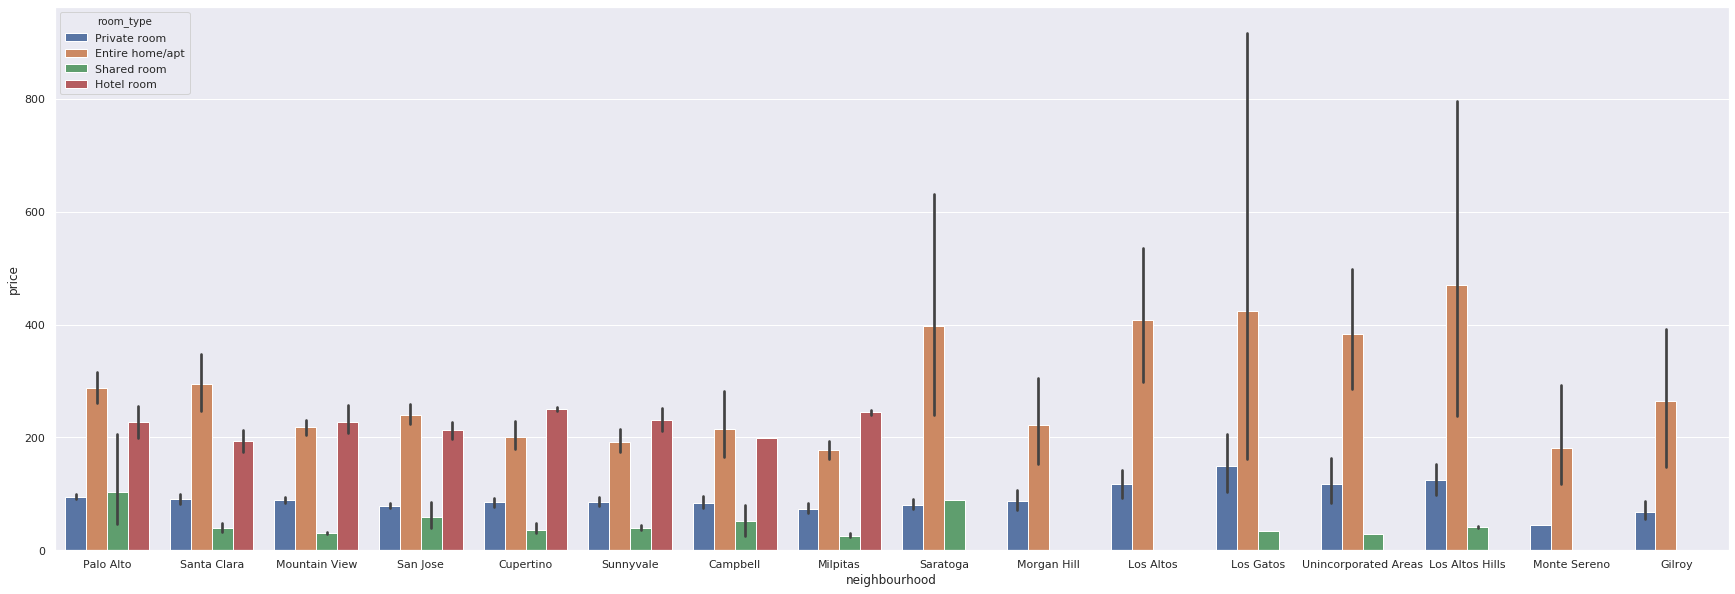

In [0]:
ax = sns.barplot(x="neighbourhood", y="price", hue="room_type", data=listings)
sns.set(rc={'figure.figsize':(25,10)})

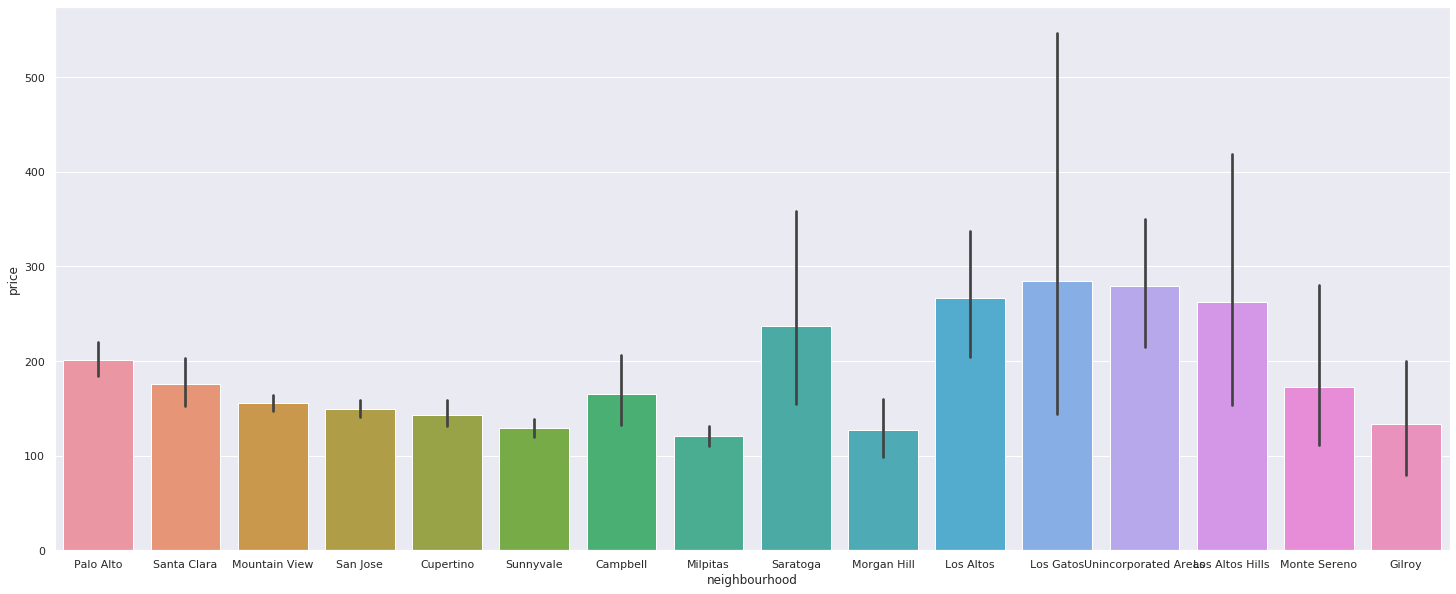

In [0]:
ax = sns.barplot(x="neighbourhood", y="price", data=listings)
sns.set(rc={'figure.figsize':(55,10)})

# Duration distribution graphs

In [0]:
term_df['count'] = listings.groupby('minimum_nights').id.count()
term_df['minimum_nights'] = term_df.index
term_df = pd.DataFrame(data=term_df)
term_df['minimum_nights'] = term_df['minimum_nights'].astype(str).astype(int)

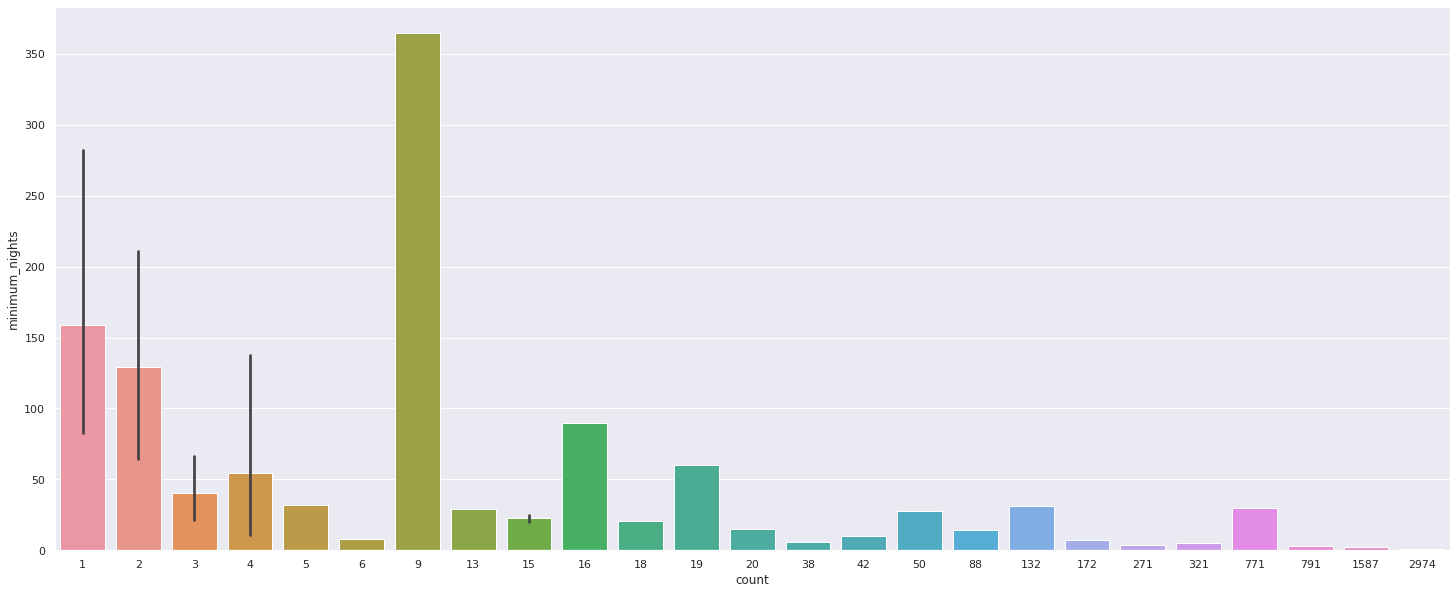

In [0]:
ax = sns.barplot(x="count", y="minimum_nights", data=term_df)
sns.set(rc={'figure.figsize':(15,10)})

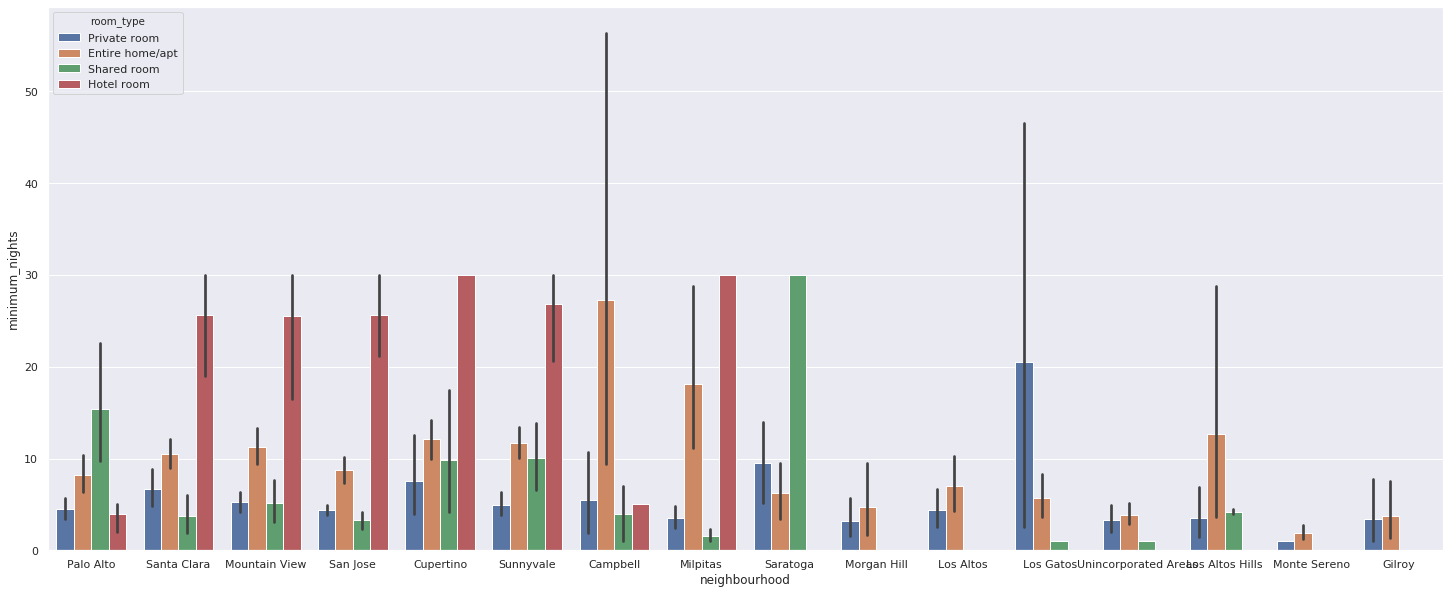

In [0]:
ax = sns.barplot(x="neighbourhood", y="minimum_nights", hue='room_type', data=listings)
sns.set(rc={'figure.figsize':(25,10)})

# Various trend graphs

In [0]:
listings['last_review'] = pd.to_datetime(listings['last_review'], infer_datetime_format=True)
listings['last_review_month'] = pd.DatetimeIndex(listings['last_review']).month


[(736882.0, 737318.0)]

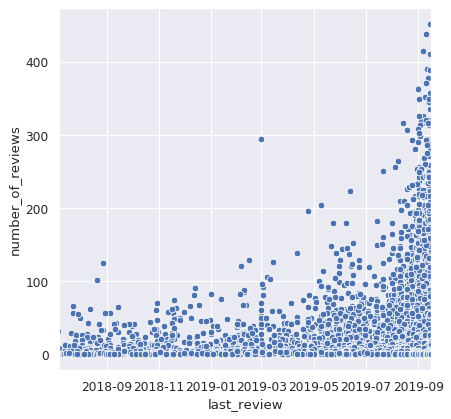

In [0]:
plt.figure(figsize=(6, 6), dpi=80)
ax = sns.scatterplot(x="last_review", y="number_of_reviews", data=listings)
ax.set(xlim=('2018-07-07', '2019-09-16'))

[(0, 2000)]

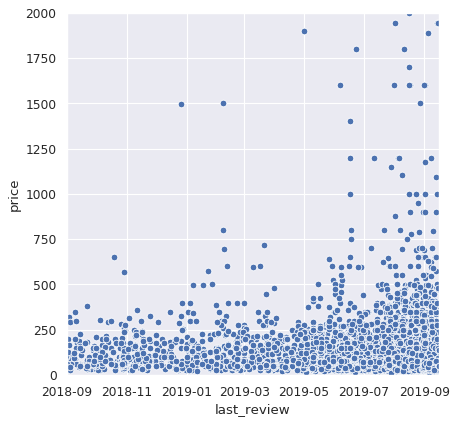

In [0]:
plt.figure(figsize=(6, 6), dpi=80)
ax = sns.scatterplot(x="last_review", y="price", data=listings)
ax.set(xlim=('2018-09-01', '2019-09-16'))
ax.set(ylim=(0, 2000))

[(0, 6000)]

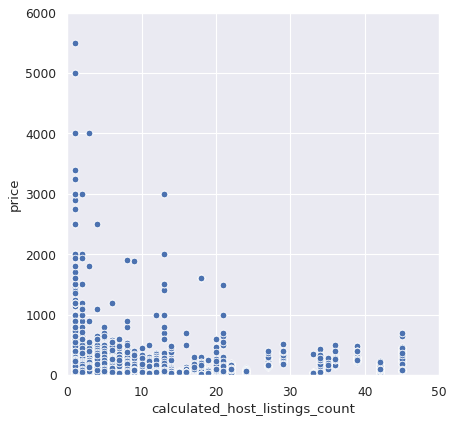

In [0]:
plt.figure(figsize=(6, 6), dpi=80)
ax = sns.scatterplot(x="calculated_host_listings_count", y="price", data=listings)
ax.set(xlim=(0,50))
ax.set(ylim=(0, 6000))

[(0, 2000)]

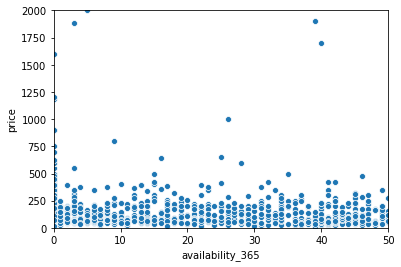

In [0]:
ax = sns.scatterplot(x="availability_365", y="price", data=listings)
ax.set(xlim=(0,50))
ax.set(ylim=(0, 2000))

# Random other analysis

In [0]:
listings.pivot_table(index='neighbourhood',columns='room_type',values='price',aggfunc='mean')

room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood,,,,
Campbell,214.101266,199.000000,84.000000,52.500000
Cupertino,201.450704,250.578947,84.819355,36.818182
Gilroy,265.142857,NaN,67.642857,NaN
Los Altos,408.000000,NaN,117.416667,NaN
Los Altos Hills,470.227273,NaN,125.000000,41.500000
Los Gatos,423.302326,NaN,148.738095,34.000000
Milpitas,177.602740,245.052632,73.742138,25.733333
Monte Sereno,181.533333,NaN,45.000000,NaN
Morgan Hill,222.615385,NaN,86.645161,NaN


In [0]:
neighbourhood_DF=listings.groupby('neighbourhood').id.count()
neighbourhoodPrice_DF=listings.groupby('neighbourhood').price.mean()
mergeDF=pd.merge(neighbourhood_DF,neighbourhoodPrice_DF,on='neighbourhood')

In [0]:
mergeDF.sort_values(by=['price'], inplace=True)

In [0]:
mergeDF.head()

,id,price
neighbourhood,,
Milpitas,285,120.659649
Morgan Hill,44,126.818182
Sunnyvale,766,128.915144
Gilroy,21,133.476190
Cupertino,327,143.483180


In [0]:
#ax = sns.barplot(x="id", y="price", data=mergeDF)
ax = mergeDF.plot.bar('id', 'price')
ax.set_xticklabels(mergeDF['neighbourhood'])

# Time graphs

In [0]:
#replacing NaN values with 0
calendar.fillna(0, inplace=True)
calendar = calendar[calendar.price != 0]

In [0]:
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
calendar['dayofweek'] = pd.DatetimeIndex(calendar['date']).dayofweek

In [0]:
#Extracting prices from the table

import re

calendar['adjusted_price'] = calendar['adjusted_price'].astype(str)

for index,row in calendar.iterrows():
    calendar.at[index, 'adjusted_price'] = float(re.sub('[^0-9.]+','', calendar.at[index, 'adjusted_price']))


In [0]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,dayofweek
0,1175047,2019-09-17,f,67,135,3.0,21.0,2019,9,1
1,4952,2019-09-17,f,67,55,2.0,365.0,2019,9,1
2,4952,2019-09-18,f,67,55,2.0,365.0,2019,9,2
3,4952,2019-09-19,f,67,55,2.0,365.0,2019,9,3
4,4952,2019-09-20,f,67,55,2.0,365.0,2019,9,4


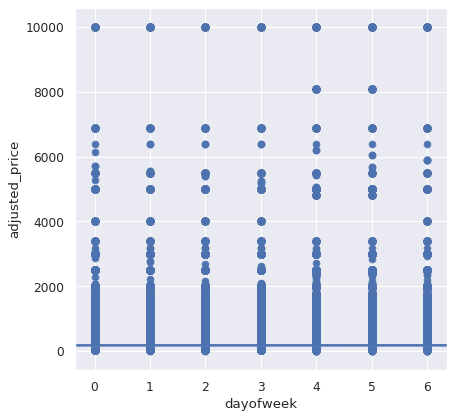

In [0]:
plt.figure(figsize=(6, 6), dpi=80)
ax = sns.scatterplot(x='dayofweek', y="adjusted_price", data=calendar)
sns.regplot(x="dayofweek", y="adjusted_price", data=calendar);

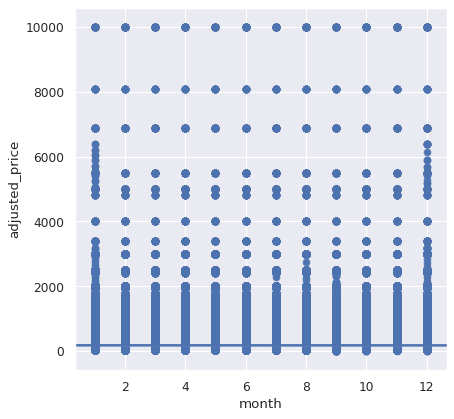

In [0]:
plt.figure(figsize=(6, 6), dpi=80)
ax = sns.scatterplot(x='month', y="adjusted_price", data=calendar)
sns.regplot(x="month", y="adjusted_price", data=calendar);

# Map graphs

In [0]:
import folium
from folium import plugins

ba_map = folium.Map(location=[37.8272, -122.2913],zoom_start =10)
data_loc= listings[['latitude','longitude']].values
data_loc =data_loc.tolist()
hm = plugins.HeatMap(data_loc)
hm.add_to(ba_map)
ba_map

In [0]:
import plotly.express as px 

fig = px.scatter_mapbox(listings, lat="latitude", lon="longitude", hover_name="neighbourhood", hover_data=["price"], color='price', size='price',
                        zoom=3, height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Price(the target) will need log transformation since its Right-Skewed

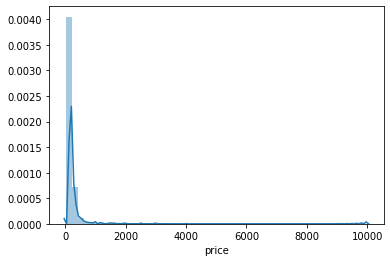

In [0]:
%matplotlib inline

sns.distplot(listings['price']);

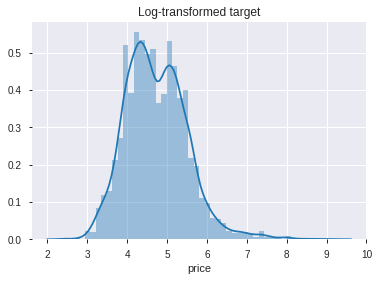

In [0]:
price_log = np.log1p(listings['price'])
sns.distplot(price_log)
plt.title('Log-transformed target'); # price here is log dollars

# Maybe even remove the outliers -??

In [0]:
listings = listings[(listings['price'] >= np.percentile(listings['price'], 0.5)) & 
        (listings['price'] <= np.percentile(listings['price'], 99.5)) & 
        (listings['latitude'] >= np.percentile(listings['latitude'], 0.05)) & 
        (listings['latitude'] < np.percentile(listings['latitude'], 99.95)) &
        (listings['longitude'] >= np.percentile(listings['longitude'], 0.05)) & 
        (listings['longitude'] <= np.percentile(listings['longitude'], 99.95))]

# Prepare to fit the model

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(listings, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [60]:
train.shape, val.shape, test.shape

((4758, 16), (1190, 16), (1487, 16))

In [61]:
# The status_group column is the target
target = 'price'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id', 'neighbourhood_group'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood', 'room_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [63]:
#Baseline

y_pred = []

for x in range(1,len(y_val)+1):
  y_pred.append(listings['price'].mean())

print('MAE for RFR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for RFR: ', r2_score(y_val, y_pred))

MAE for RFR:  117.92077127824902
R2 Score for RFR:  -0.00027665870034865314


In [64]:
#Linear Regression with OneHotEncoder

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    LinearRegression()
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for LR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for LR: ', r2_score(y_val, y_pred))

MAE for LR:  82.23493036314768
R2 Score for LR:  0.061258847270846184


In [65]:
#Linear Regression with OrdinalEncoder

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    LinearRegression()
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for LR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for LR: ', r2_score(y_val, y_pred))

MAE for LR:  87.12655903487287
R2 Score for LR:  0.040949125377212514


In [72]:
#Ridge Regression 

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RidgeCV()
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

print('MAE for RR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for RR: ', r2_score(y_val, y_pred))

MAE for RR:  30570.187316877356
R2 Score for RR:  -9863.919844516045


In [73]:
# Try Decision Tree 

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeRegressor(criterion='mse',max_depth=100)
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(mean_absolute_error(y_val, y_pred))
print('R2 Score for LR: ', r2_score(y_val, y_pred))

107.46218487394958
R2 Score for LR:  -0.28764407030965433


Text(0.5, 1.0, 'Top 20 features from DecisionTree Regressor')

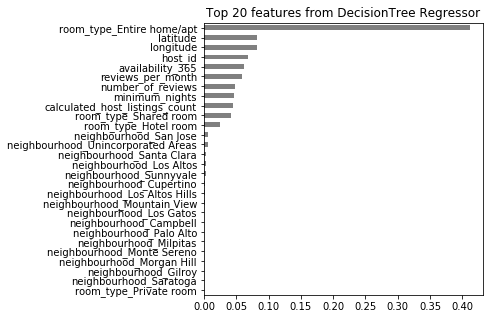

In [74]:
#Get Feature Importance by DecisionTreeRegressor 

rf = pipeline.named_steps['decisiontreeregressor']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(rf.feature_importances_, encoded_columns)
plt.figure(figsize=(5,5))
importances.sort_values().plot.barh(color='grey')
plt.title(f'Top {n} features from DecisionTree Regressor')

In [76]:
# Try Random Forest

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators= 421, random_state = 42)
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for RFR: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for RFR: ', r2_score(y_val, y_pred))

MAE for RFR:  70.65825529043987
R2 Score for RFR:  0.19183506398582417


In [79]:
# Using Gradient Boosting 

from xgboost import XGBRFRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRFRegressor(n_estimators=421, random_state=42, n_jobs=-1, objective ='reg:squarederror')
)

pipeline.fit(X_train, y_train)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('MAE for GB: ', mean_absolute_error(y_val, y_pred))
print('R2 Score for GB: ', r2_score(y_val, y_pred))

MAE for GB:  81.84608757275493
R2 Score for GB:  0.054831002081800584


# Plot Feature importance using RandomForest Regressor

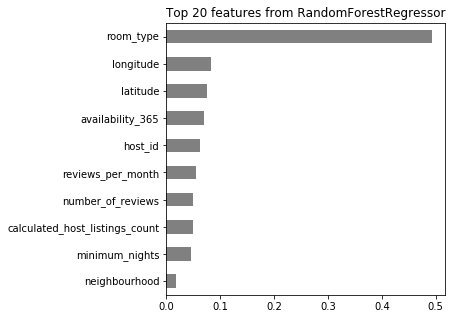

In [22]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(5,5))
plt.title(f'Top {n} features from RandomForestRegressor')
importances.sort_values()[-n:].plot.barh(color='grey');

# PDP visualization for Room Type

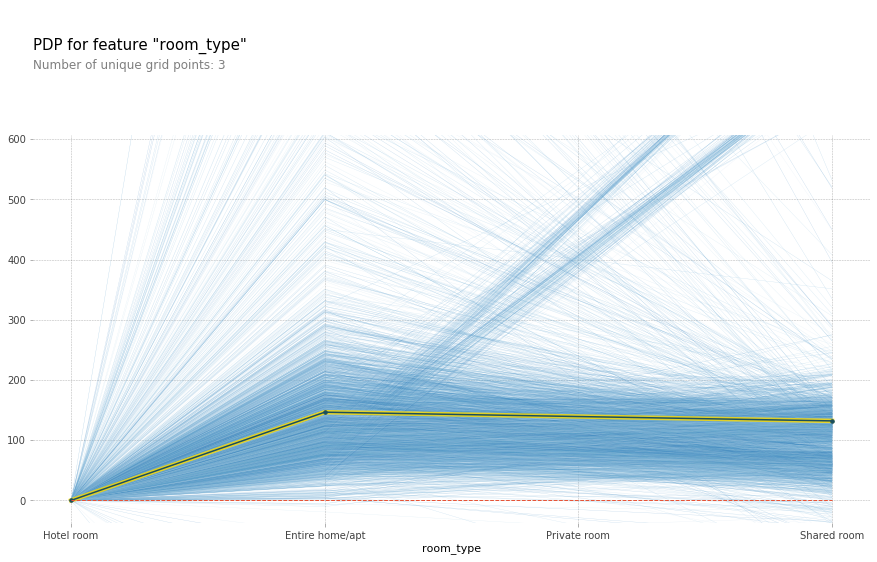

In [32]:
# Use Pdpbox - Automated version

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

model = XGBRFRegressor(n_estimators=500, random_state=42, n_jobs=-1, objective ='reg:squarederror', max_depth=50, alpha = 100 )
model.fit(X_encoded, y_train)

feature = 'room_type'

for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()
figsize = (2,2)

pdp_dist = pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp_plot(pdp_dist, feature, plot_lines=True)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room']);

In [25]:
X_imputed.columns

RangeIndex(start=0, stop=10, step=1)

#PDP for another feature, "availability_365'

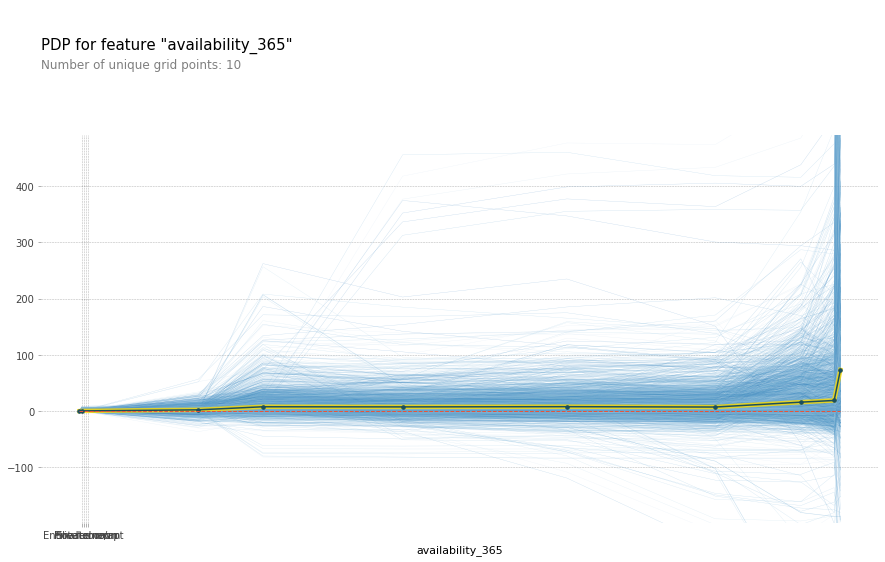

In [33]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'availability_365'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

pdp_dist = pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp_plot(pdp_dist, feature, plot_lines=True)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room']);

#PDP with 2 features (Room Type, Neighbourhood)

(None, <a list of 7 Text yticklabel objects>)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


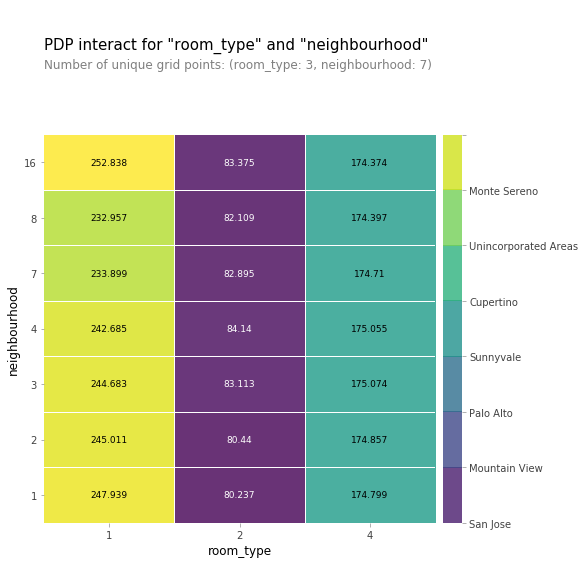

In [34]:
features = ['room_type', 'neighbourhood']

from pdpbox.pdp import pdp_interact_plot, pdp_interact

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room'])

# Manually change the xticks labels


plt.yticks([1, 2, 3, 4, 5, 10, 16], ['San Jose', 'Mountain View', 'Palo Alto', 'Sunnyvale', 'Cupertino', 'Unincorporated Areas', 'Monte Sereno'])


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f65fb9b56d8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f65fb6c80b8>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


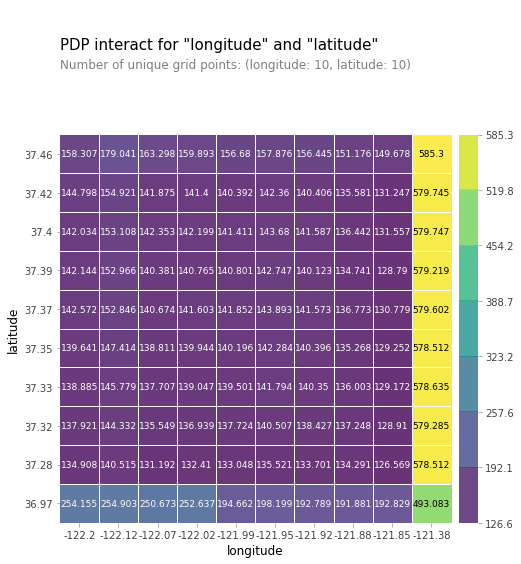

In [34]:
features = ['longitude', 'latitude']

from pdpbox.pdp import pdp_interact_plot, pdp_interact

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
#plt.xticks([1, 2, 3, 4], ['Hotel room', 'Entire home/apt', 'Private room', 'Shared room'])

# Manually change the xticks labels


#plt.yticks([1, 2, 3, 4, 5, 10, 16], ['San Jose', 'Mountain View', 'Palo Alto', 'Sunnyvale', 'Cupertino', 'Unincorporated Areas', 'Monte Sereno'])


# Feature Importance using ELI5 library

In [35]:
transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBRFRegressor(
    n_estimators=1000, 
    max_depth=10, 
    objective='reg:squarederror', 
    n_jobs=-1, 
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='mae', early_stopping_rounds=20)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', n_iter=3)
permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

     |████████████████████████████████| 112kB 2.8MB/s 
[0]	validation_0-mae:59.9718	validation_1-mae:72.9172
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.


Using TensorFlow backend.


Weight,Feature
54.3924 ± 2.3388,room_type
6.2618 ± 1.7410,calculated_host_listings_count
5.5087 ± 1.5952,availability_365
4.3235 ± 0.8850,minimum_nights
2.7648 ± 2.4586,latitude
2.4176 ± 0.3254,longitude
2.3992 ± 0.0918,reviews_per_month
1.4038 ± 0.3176,host_id
1.3917 ± 1.9728,number_of_reviews
0.3898 ± 0.4001,neighbourhood


In [0]:
X_train = X_train.replace(" ", "_")

#Randomized Search and Cross validation

In [80]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(300, 700), 
    'max_depth': [50, 100, 150, 200, None],
    'max_features': uniform(0, 1), 
}

transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer())
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
search.fit(X_train_transformed, y_train_log);


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished


In [81]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)


Best hyperparameters {'max_depth': None, 'max_features': 0.43194501864211576, 'n_estimators': 348}
Cross-validation MAE 0.30729843759907116


In [0]:
X_train.shape, X_test.shape

((4758, 11), (1487, 11))